# A guide to Time series analysis

In [6]:
import pandas as pd

In [15]:
df = pd.read_csv("Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [18]:
# Remove old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Remove not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [19]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [20]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


# Data Preprocessing
Make sure the data is equidistant in timestamp

In [27]:
df['date_dist'] = df['date'] - df['date'].shift(1)

In [30]:
df['date_dist'].sum(), len(df)

(Timedelta('4198 days 00:00:00'), 4199)

## Missing data
A few ways to fill missing data
- Fill NAN with zero
- Fill NAN with statistic ex: median or mean
- Fill NAN with interpolated value
- Fill NAN with most frequent (mode)

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
df.isnull().sum()

date                      0
rainfall                  0
depth_to_groundwater     27
temperature               0
drainage_volume          26
river_hydrometry        150
date_dist                 1
dtype: int64

In [61]:
import numpy as np

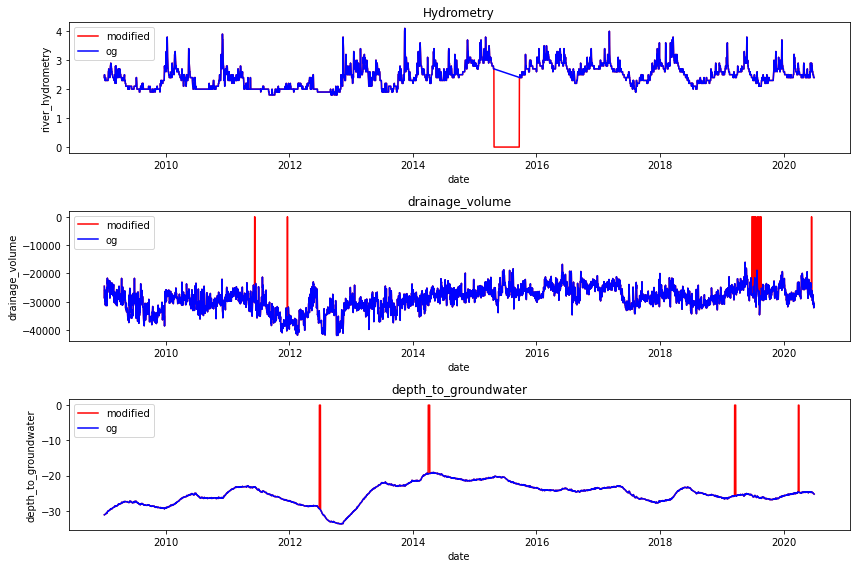

In [95]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize = (12,8))

og_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0,np.nan)

og_groundwater = df['depth_to_groundwater']
df['depth_to_groundwater'] = df['depth_to_groundwater'].replace(0,np.nan)

og_drainage = df['drainage_volume']
df['drainage_volume'] = df['drainage_volume'].replace(0,np.nan)

sns.lineplot(ax=ax[0], x = df['date'], y = df['river_hydrometry'].fillna(0), color = 'red', label = 'modified')
sns.lineplot(ax=ax[0], x = df['date'], y = og_hydrometry, color = 'blue', label = 'og')
ax[0].set_title('Hydrometry')

sns.lineplot(ax=ax[1], x = df['date'], y = df['drainage_volume'].fillna(0), color = 'red', label = 'modified')
sns.lineplot(ax=ax[1], x = df['date'], y = og_drainage, color = 'blue', label = 'og')
ax[1].set_title('drainage_volume')

sns.lineplot(ax=ax[2], x = df['date'], y = df['depth_to_groundwater'].fillna(0), color = 'red', label = 'modified')
sns.lineplot(ax=ax[2], x = df['date'], y = og_groundwater, color = 'blue', label = 'og')
ax[2].set_title('depth_to_groundwater')

plt.tight_layout()

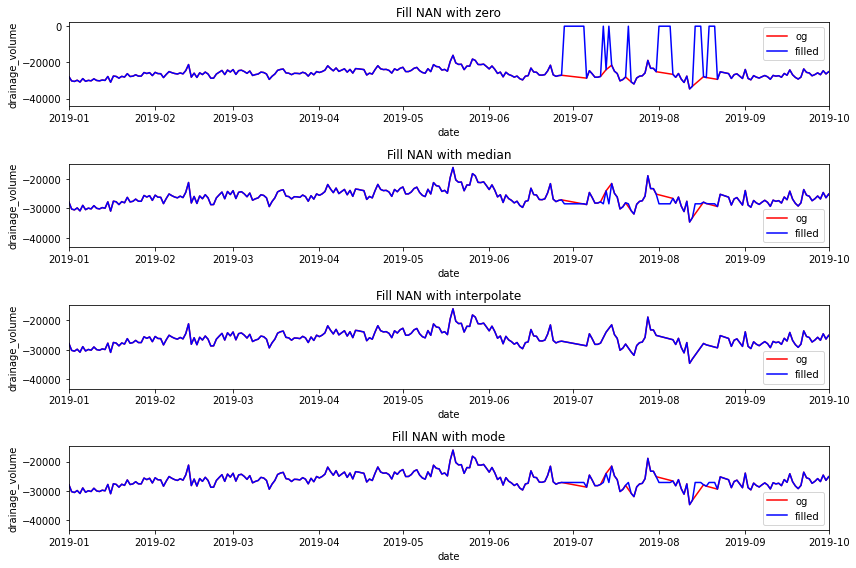

In [132]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (12,8))

sns.lineplot(ax=ax[0], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[0], x = df['date'], y = df['drainage_volume'].fillna(0), color = 'blue', label = 'filled')
ax[0].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[0].set_title('Fill NAN with zero')

sns.lineplot(ax=ax[1], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[1], x = df['date'], y = df['drainage_volume'].fillna(df['drainage_volume'].median()), color = 'blue', label = 'filled')
ax[1].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[1].set_title('Fill NAN with median')

sns.lineplot(ax=ax[2], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[2], x = df['date'], y = df['drainage_volume'].fillna(df['drainage_volume'].interpolate()), color = 'blue', label = 'filled')
ax[2].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[2].set_title('Fill NAN with interpolate')

sns.lineplot(ax=ax[3], x = df['date'], y = df['drainage_volume'], color = 'red', label = 'og')
sns.lineplot(ax=ax[3], x = df['date'], y = df['drainage_volume'].fillna(df['drainage_volume'].mode()[0]), color = 'blue', label = 'filled')
ax[3].set_xlim([date(2019, 1, 1), date(2019, 10, 1)])
ax[3].set_title('Fill NAN with mode')

plt.tight_layout()

In [134]:
# Visually interpolation looks to be the best method to fill data


In [135]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

# Feature Engineering
- Parsing date into different columns
- Time series decompisition
- Lag (Diff)

## Time series decomposition
Time series can be think of a combination of
- Level: The average value of the time series
- Trend: The increasing or decreasing value in the series
- Seasonality: The small repeating cycles
- Noise: The random variation

Two common compositions are
- Additive composition -> The above components are additive.
- Multiplicative compsition -> The above components are multiplied

In [140]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter

C:\Users\User\AppData\Local\Temp\ipykernel_2536\867297069.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear


In [148]:
from statsmodels.tsa.seasonal import seasonal_decompose

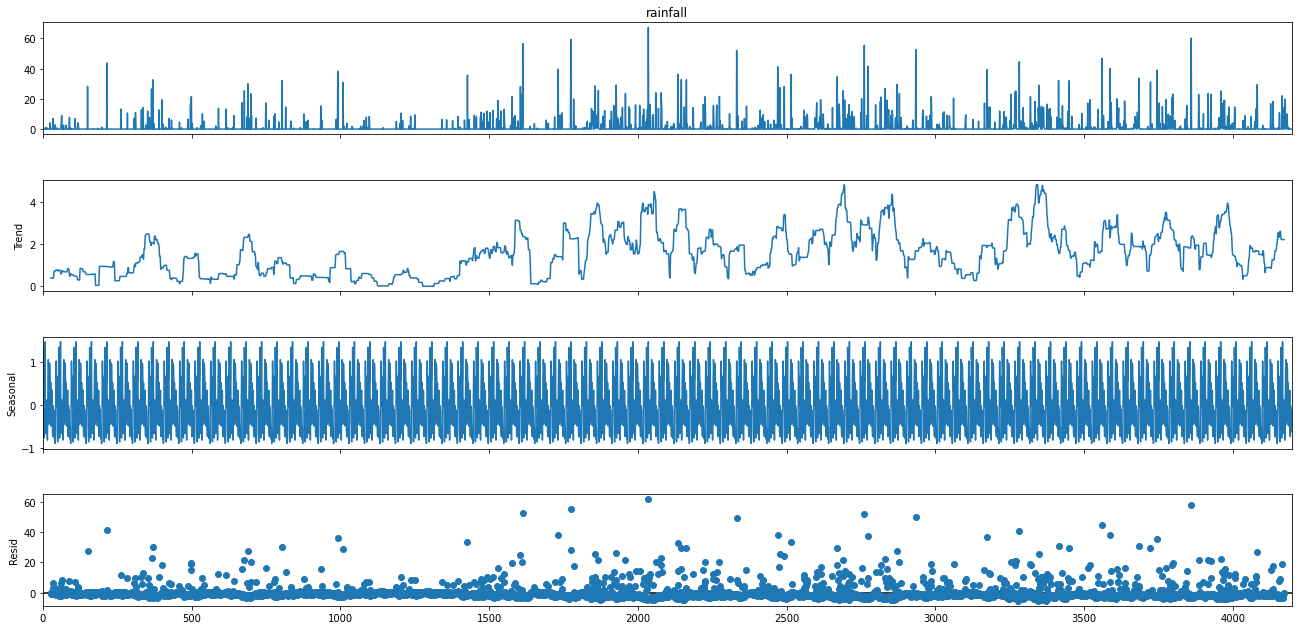

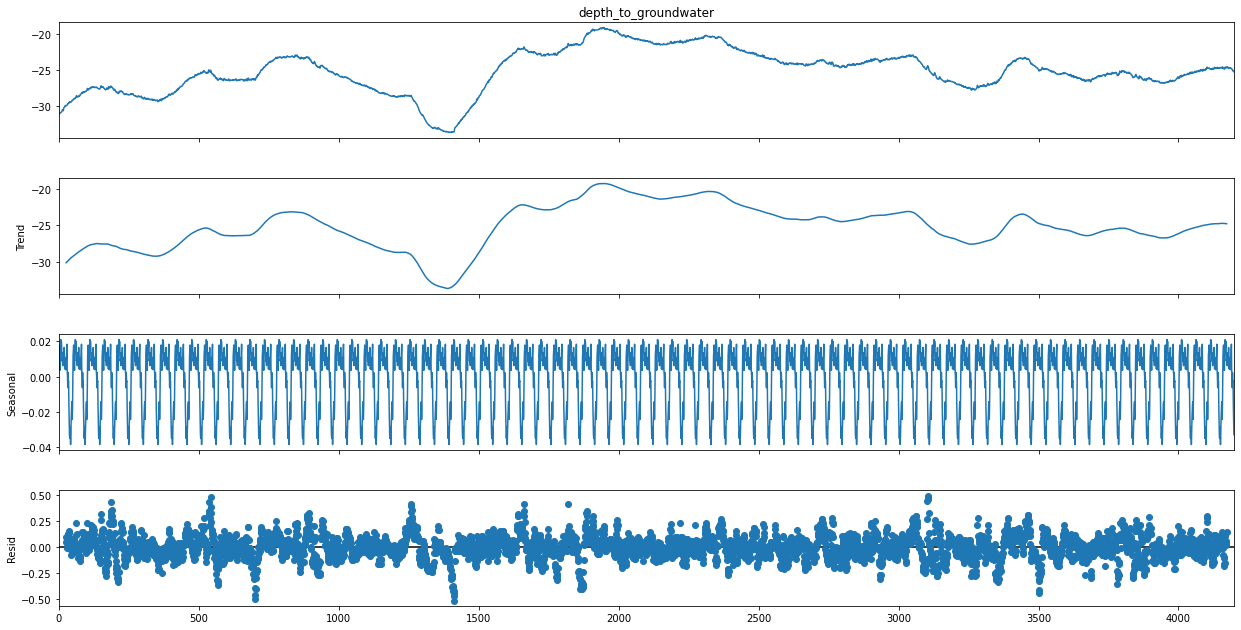

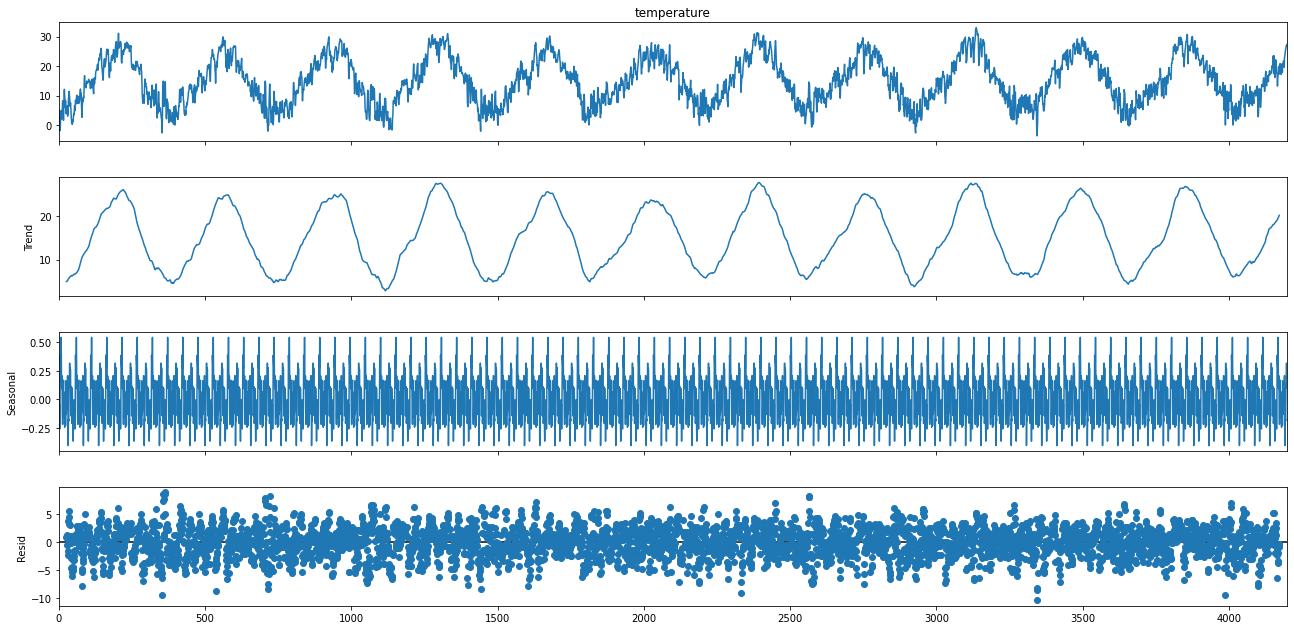

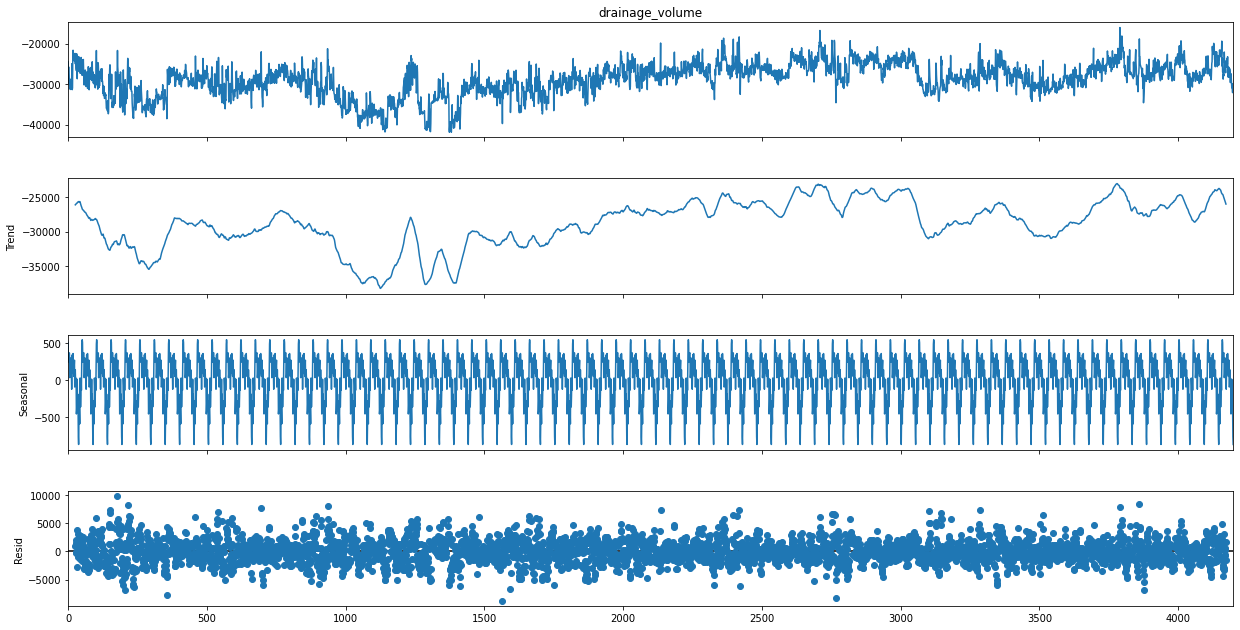

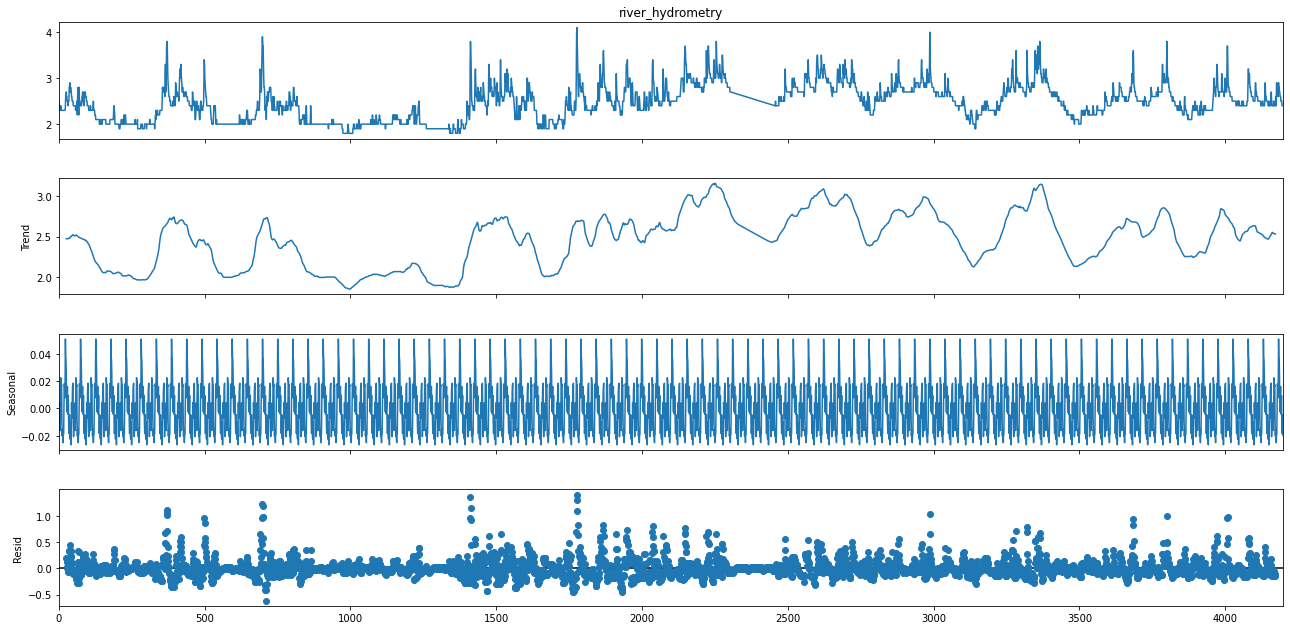

In [163]:
cols_to_decompose = ['rainfall', 'depth_to_groundwater', 'temperature',
       'drainage_volume', 'river_hydrometry']
for columns in cols_to_decompose:
    decompose_value = seasonal_decompose(df[columns], model='additive',period = 52)
    fig = decompose_value.plot()
    fig.set_size_inches((20, 10))


### How to read a decompose graph?